**Phase 1: Organize & Reproducibility**

Mount Google Drive

In [ ]:
from google.colab import drive
drive.flush_and_unmount()  # Clears existing mount (if any)
drive.mount('/content/drive')  # Triggers new authentication

# Use your actual folder path (without .csv extension)
project_path = "/content/drive/MyDrive/JAK 2.csv/"

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


Create Project Folders

In [ ]:
import os

# First, let's correctly set the project path to your desired directory
# If you want to create folders in the same directory as your CSV file:
project_path = "/content/drive/MyDrive/"

# If you want to create a dedicated project folder:
# project_path = "/content/drive/MyDrive/your_project_name/"

# Create the main project directory first (if using a dedicated folder)
os.makedirs(project_path, exist_ok=True)

# Now create the subfolder structure
folders = [
    "data/raw",
    "data/processed",
    "notebooks",
    "models",
    "results",
    "figures"
]

for folder in folders:
    full_path = os.path.join(project_path, folder)
    os.makedirs(full_path, exist_ok=True)
    print(f"Created directory: {full_path}")

print("Project folders created successfully!")

Created directory: /content/drive/MyDrive/data/raw
Created directory: /content/drive/MyDrive/data/processed
Created directory: /content/drive/MyDrive/notebooks
Created directory: /content/drive/MyDrive/models
Created directory: /content/drive/MyDrive/results
Created directory: /content/drive/MyDrive/figures
Project folders created successfully!


Install Required Libraries

In [ ]:
!pip install rdkit-pypi
!pip install xgboost lightgbm
!pip install chemprop


ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 20.9 MB/s eta 0:00:00


Import Libraries

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import lightgbm as lgb


Fix Random Seeds

In [ ]:
SEED = 42

np.random.seed(SEED)
random.seed(SEED)


ave Environment Info

In [ ]:
!pip freeze > "{project_path}/requirements_colab.txt"
print("Environment saved at:", f"{project_path}/requirements_colab.txt")


Environment saved at: /content/drive/MyDrive//requirements_colab.txt


**Phase 1: Data Ingestion & Exploration**

✅ Dataset loaded successfully!
Shape: (13487, 48)
Columns: ['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase', 'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key', 'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment', 'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE', 'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate', 'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID', 'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID', 'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction', 'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation', 'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type', 'Document ChEMBL ID', 'Source ID', 'Source Description', 'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties', 'Action Type', 'Standard Text Value', 'Value']

Missing values per column:
Mol

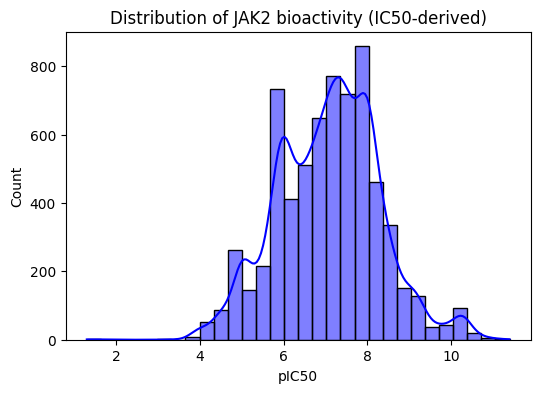


✅ Final IC50-cleaned dataset saved to: /content/drive/MyDrive/JAK2_Project/data/processed/jak2_ic50_cleaned.csv


In [ ]:
# =========================
# Phase 1 — Data Ingestion & Exploration (Auto File Fix)
# =========================

import os
import shutil
import pandas as pd
import numpy as np
from rdkit import Chem
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 0. Define project structure
# --------------------------
project_path = "/content/drive/MyDrive/JAK2_Project"

raw_path = os.path.join(project_path, "data", "raw")
processed_path = os.path.join(project_path, "data", "processed")

# Ensure folders exist
os.makedirs(raw_path, exist_ok=True)
os.makedirs(processed_path, exist_ok=True)

# --------------------------
# 1. Locate dataset
# --------------------------
default_location = "/content/drive/MyDrive/JAK 2.csv"
target_location = os.path.join(raw_path, "JAK 2.csv")

# If file is not in raw/, but in MyDrive, move/copy it
if not os.path.exists(target_location):
    if os.path.exists(default_location):
        shutil.copy(default_location, target_location)
        print(f"📂 Moved file from MyDrive to {target_location}")
    else:
        raise FileNotFoundError(
            f"❌ Could not find 'JAK 2.csv'. Please place it in:\n{default_location} or {target_location}"
        )

# --------------------------
# 2. Load dataset
# --------------------------
df = pd.read_csv(target_location, sep=";")   # change sep to ',' if needed

print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
print("Columns:", list(df.columns))

# --------------------------
# 3. Basic exploration
# --------------------------
print("\nMissing values per column:")
print(df.isnull().sum())

# --------------------------
# 4. Filter for IC50 values only
# --------------------------
df_ic50 = df[df["Standard Type"].str.upper() == "IC50"].copy()
print("\nAfter filtering IC50 only:", df_ic50.shape)

# Keep only nM units
df_ic50 = df_ic50[df_ic50["Standard Units"].str.lower() == "nm"]
print("After keeping nM units only:", df_ic50.shape)

# Drop missing Standard Values
df_ic50 = df_ic50.dropna(subset=["Standard Value"])
print("After dropping missing Standard Values:", df_ic50.shape)

# --------------------------
# 5. Convert IC50 → pIC50
# --------------------------
df_ic50["IC50_nM"] = df_ic50["Standard Value"].astype(float)
df_ic50["IC50_M"] = df_ic50["IC50_nM"] * 1e-9
df_ic50["pIC50_calc"] = -np.log10(df_ic50["IC50_M"])

# --------------------------
# 6. Validate SMILES
# --------------------------
df_ic50 = df_ic50[df_ic50["Smiles"].apply(lambda x: Chem.MolFromSmiles(str(x)) is not None)]
print("After removing invalid SMILES:", df_ic50.shape)

# --------------------------
# 7. Handle duplicates: average pIC50 if same SMILES appears multiple times
# --------------------------
df_ic50 = df_ic50.groupby("Smiles").agg({
    "pIC50_calc": "mean",
    "Molecule ChEMBL ID": "first",
    "Molecule Name": "first"
}).reset_index()

print("After handling duplicates (unique compounds):", df_ic50.shape)

# --------------------------
# 8. Compare with pChEMBL if available
# --------------------------
if "pChEMBL Value" in df.columns:
    print("\nComparing computed pIC50 vs provided pChEMBL (if available)...")
    df_compare = df.merge(df_ic50, on="Smiles", how="inner")
    df_compare = df_compare[["Smiles", "pChEMBL Value", "pIC50_calc"]].dropna()
    if not df_compare.empty:
        corr = df_compare["pChEMBL Value"].corr(df_compare["pIC50_calc"])
        print(f"Correlation between provided pChEMBL and computed pIC50: {corr:.3f}")

# --------------------------
# 9. Summary statistics
# --------------------------
print("\nFinal pIC50 stats:")
print(df_ic50["pIC50_calc"].describe())

# --------------------------
# 10. Plot distribution
# --------------------------
plt.figure(figsize=(6,4))
sns.histplot(df_ic50["pIC50_calc"], bins=30, kde=True, color="blue")
plt.xlabel("pIC50")
plt.title("Distribution of JAK2 bioactivity (IC50-derived)")
plt.show()

# --------------------------
# 11. Save cleaned dataset
# --------------------------
output_path = os.path.join(processed_path, "jak2_ic50_cleaned.csv")
df_ic50.to_csv(output_path, index=False)
print("\n✅ Final IC50-cleaned dataset saved to:", output_path)


**Phase 2: Cheminformatics Filtering**

✅ Loaded cleaned dataset: (6706, 4)
After Lipinski filter: (5419, 9)
After QED filter (>=0.35): (5280, 9)

✅ Final filtered dataset saved to: /content/drive/MyDrive/JAK2_Project/data/processed/jak2_filtered.csv


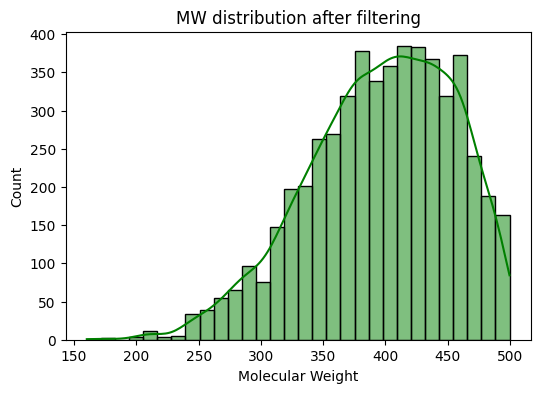

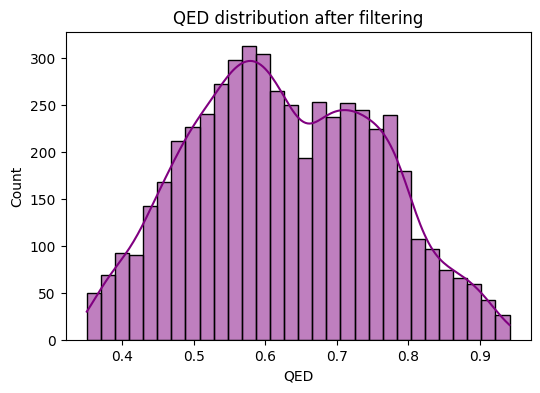

In [ ]:
# =========================
# Phase 2 — Cheminformatics Filtering (Fixed)
# =========================

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, QED

# --------------------------
# 0. Define project paths
# --------------------------
project_path = "/content/drive/MyDrive/JAK2_Project"
processed_path = os.path.join(project_path, "data", "processed")

# Input from Phase 1
input_path = os.path.join(processed_path, "jak2_ic50_cleaned.csv")

if not os.path.exists(input_path):
    raise FileNotFoundError(f"❌ Could not find Phase 1 dataset at: {input_path}")

# --------------------------
# 1. Load dataset
# --------------------------
df = pd.read_csv(input_path)
print("✅ Loaded cleaned dataset:", df.shape)

# --------------------------
# 2. Calculate Lipinski descriptors + QED
# --------------------------
def compute_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return pd.Series([None, None, None, None, None])
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    qed_score = QED.qed(mol)
    return pd.Series([mw, logp, hbd, hba, qed_score])

df_props = df["Smiles"].apply(compute_properties)
df_props.columns = ["MW", "LogP", "HBD", "HBA", "QED"]

# Merge descriptors into main dataframe
df = pd.concat([df, df_props], axis=1)

# --------------------------
# 3. Apply Lipinski filter
# --------------------------
df_lipinski = df[
    (df["MW"] <= 500) &
    (df["LogP"] <= 5) &
    (df["HBD"] <= 5) &
    (df["HBA"] <= 10)
].copy()
print("After Lipinski filter:", df_lipinski.shape)

# --------------------------
# 4. Apply QED filter
# --------------------------
df_qed = df_lipinski[df_lipinski["QED"] >= 0.35].copy()
print("After QED filter (>=0.35):", df_qed.shape)

# --------------------------
# 5. (Optional) PAINS and Brenk filters
# --------------------------
# Placeholder for later implementation

# --------------------------
# 6. Save filtered dataset
# --------------------------
output_path = os.path.join(processed_path, "jak2_filtered.csv")
df_qed.to_csv(output_path, index=False)
print("\n✅ Final filtered dataset saved to:", output_path)

# --------------------------
# 7. Distribution plots
# --------------------------
plt.figure(figsize=(6,4))
sns.histplot(df_qed["MW"], bins=30, kde=True, color="green")
plt.xlabel("Molecular Weight")
plt.title("MW distribution after filtering")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df_qed["QED"], bins=30, kde=True, color="purple")
plt.xlabel("QED")
plt.title("QED distribution after filtering")
plt.show()


**Phase 3: Feature Engineering**

In [ ]:
# =========================
# Phase 3 — Feature Engineering (Fixed)
# =========================

import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.preprocessing import StandardScaler

# --------------------------
# 0. Define paths
# --------------------------
project_path = "/content/drive/MyDrive/JAK2_Project"
processed_path = os.path.join(project_path, "data", "processed")

# Input from Phase 2
input_path = os.path.join(processed_path, "jak2_filtered.csv")

if not os.path.exists(input_path):
    raise FileNotFoundError(f"❌ Could not find Phase 2 dataset at: {input_path}")

# --------------------------
# 1. Load dataset
# --------------------------
df = pd.read_csv(input_path)
print("✅ Loaded filtered dataset:", df.shape)

# --------------------------
# 2. Morgan Fingerprints (ECFP4)
# --------------------------
from rdkit import DataStructs

def mol_to_morgan(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros((nBits,), dtype=int)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    arr = np.zeros((nBits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

fps = df["Smiles"].apply(lambda x: mol_to_morgan(str(x), radius=2, nBits=1024))
X_fps = np.array(fps.tolist())
print("Fingerprints shape:", X_fps.shape)

# --------------------------
# 3. RDKit Descriptors
# --------------------------
descriptor_names = [desc_name[0] for desc_name in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

def calc_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [np.nan] * len(descriptor_names)
    return calc.CalcDescriptors(mol)

desc_values = df["Smiles"].apply(calc_descriptors)
X_desc = pd.DataFrame(desc_values.tolist(), columns=descriptor_names)

# Clean descriptors (remove NaN/inf and constant columns)
X_desc = X_desc.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how="any")
X_desc = X_desc.loc[:, X_desc.std() > 0]
print("Descriptors shape (after cleaning):", X_desc.shape)

# --------------------------
# 4. Standardize descriptors
# --------------------------
scaler = StandardScaler()
X_desc_scaled = scaler.fit_transform(X_desc)

# --------------------------
# 5. Target variable
# --------------------------
y = df["pIC50_calc"].values
print("Target shape:", y.shape)

# --------------------------
# 6. Save feature sets
# --------------------------
np.save(os.path.join(processed_path, "X_fingerprints.npy"), X_fps)
np.save(os.path.join(processed_path, "X_descriptors.npy"), X_desc_scaled)
np.save(os.path.join(processed_path, "y.npy"), y)

print("\n✅ Feature sets saved!")
print("X_fingerprints:", X_fps.shape)
print("X_descriptors:", X_desc_scaled.shape)
print("y:", y.shape)


✅ Loaded filtered dataset: (5280, 9)


Streaming output truncated to the last 5000 lines.
[20:43:44] DEPRECATION WARNING: please use MorganGenerator
[20:43:44] DEPRECATION WARNING: please use MorganGenerator
[20:43:44] DEPRECATION WARNING: please use MorganGenerator
[20:43:44] DEPRECATION WARNING: please use MorganGenerator
[20:43:44] DEPRECATION WARNING: please use MorganGenerator
[20:43:44] DEPRECATION WARNING: please use MorganGenerator
[20:43:44] DEPRECATION WARNING: please use MorganGenerator
[20:43:44] DEPRECATION WARNING: please use MorganGenerator
[20:43:44] DEPRECATION WARNING: please use MorganGenerator
[20:43:44] DEPRECATION WARNING: please use MorganGenerator
[20:43:44] DEPRECATION WARNING: please use MorganGenerator
[20:43:44] DEPRECATION WARNING: please use MorganGenerator
[20:43:44] DEPRECATION WARNING: please use MorganGenerator
[20:43:44] DEPRECATION WARNING: please use MorganGenerator
[20:43:44] DEPRECATION WARNING: please use MorganGenerator
[20:43:44] DEPRECATION WARNING: please use MorganGenerator
[20:4

Fingerprints shape: (5280, 1024)
Descriptors shape (after cleaning): (5280, 195)
Target shape: (5280,)

✅ Feature sets saved!
X_fingerprints: (5280, 1024)
X_descriptors: (5280, 195)
y: (5280,)


**Phase 4 — Feature Selection**

✅ Loaded feature sets
Descriptors shape: (5280, 195)
Fingerprints shape: (5280, 1024)
Target shape: (5280,)
After variance filter (descriptors): (5280, 195)
After correlation filter (descriptors): (5280, 154)
After RFE (descriptors): (5280, 50)


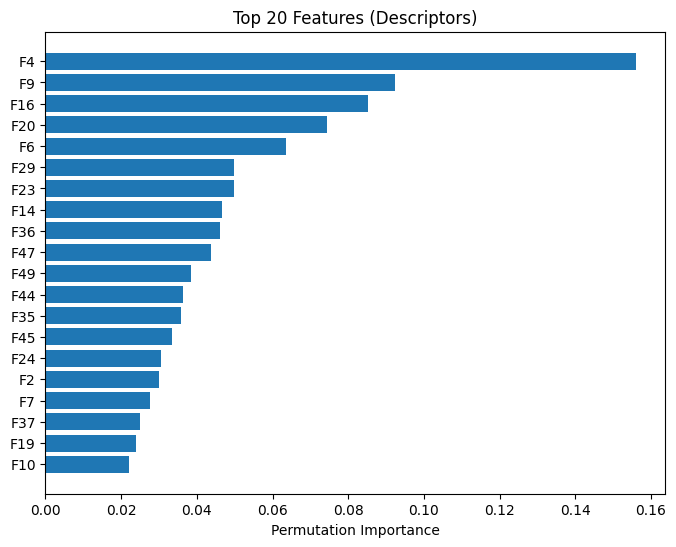


✅ Final feature sets saved!
X_desc_selected: (5280, 50)
X_fps_selected: (5280, 1024)


In [ ]:
# =========================
# Phase 4 — Feature Selection (Fixed)
# =========================

import os
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# --------------------------
# 0. Define paths
# --------------------------
project_path = "/content/drive/MyDrive/JAK2_Project"
processed_path = os.path.join(project_path, "data", "processed")

# --------------------------
# 1. Load feature sets
# --------------------------
X_desc_path = os.path.join(processed_path, "X_descriptors.npy")
X_fps_path = os.path.join(processed_path, "X_fingerprints.npy")
y_path = os.path.join(processed_path, "y.npy")

for path in [X_desc_path, X_fps_path, y_path]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"❌ Missing file: {path}")

X_desc = np.load(X_desc_path)
X_fps = np.load(X_fps_path)
y = np.load(y_path)

print("✅ Loaded feature sets")
print("Descriptors shape:", X_desc.shape)
print("Fingerprints shape:", X_fps.shape)
print("Target shape:", y.shape)

# --------------------------
# 2. Remove low-variance features
# --------------------------
selector = VarianceThreshold(threshold=0.01)  # drop near-constant features
X_desc_var = selector.fit_transform(X_desc)
print("After variance filter (descriptors):", X_desc_var.shape)

# --------------------------
# 3. Remove highly correlated features
# --------------------------
df_desc = pd.DataFrame(X_desc_var)
corr_matrix = df_desc.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
df_desc_clean = df_desc.drop(columns=to_drop, axis=1)
X_desc_clean = df_desc_clean.values
print("After correlation filter (descriptors):", X_desc_clean.shape)

# --------------------------
# 4. Recursive Feature Elimination (RFE)
# --------------------------
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rfe = RFE(rf, n_features_to_select=50, step=10)  # select top 50 features
X_desc_rfe = rfe.fit_transform(X_desc_clean, y)
print("After RFE (descriptors):", X_desc_rfe.shape)

# --------------------------
# 5. Permutation Importance
# --------------------------
rf.fit(X_desc_rfe, y)
result = permutation_importance(
    rf, X_desc_rfe, y, n_repeats=10, random_state=42, n_jobs=-1
)

# Plot top 20 features
sorted_idx = result.importances_mean.argsort()[-20:]
plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), [f"F{idx}" for idx in sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Top 20 Features (Descriptors)")
plt.show()

# --------------------------
# 6. Save final selected features
# --------------------------
np.save(os.path.join(processed_path, "X_desc_selected.npy"), X_desc_rfe)
np.save(os.path.join(processed_path, "X_fps_selected.npy"), X_fps)  # keep all fingerprints

print("\n✅ Final feature sets saved!")
print("X_desc_selected:", X_desc_rfe.shape)
print("X_fps_selected:", X_fps.shape)


**Phase 5 — Modeling**

Loaded shapes -> X_desc: (5280, 50) y: (5280,)

🔹 Running model: RandomForest
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
RandomForest → RMSE: 0.8524, MAE: 0.6465, R²: 0.5169, Pearson: 0.7330

🔹 Running model: SVR
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
SVR → RMSE: 0.8258, MAE: 0.6042, R²: 0.5465, Pearson: 0.7406

🔹 Running model: KNN
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
KNN → RMSE: 0.8482, MAE: 0.5992, R²: 0.5216, Pearson: 0.7276

🔹 Running model: GradientBoosting
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fi

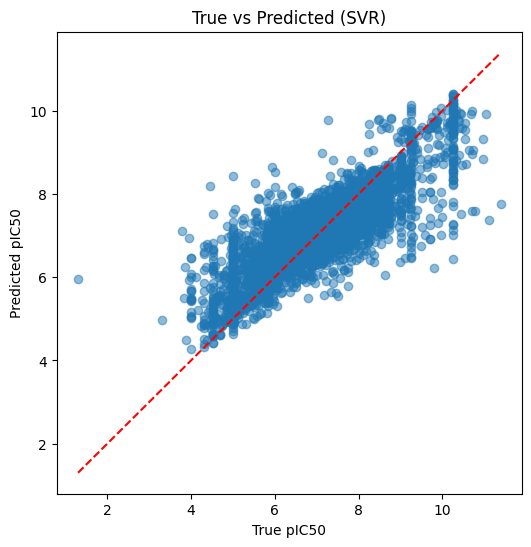


📊 Summary of all models:
RandomForest: RMSE=0.8524, MAE=0.6465, R²=0.5169, Pearson=0.7330
SVR: RMSE=0.8258, MAE=0.6042, R²=0.5465, Pearson=0.7406
KNN: RMSE=0.8482, MAE=0.5992, R²=0.5216, Pearson=0.7276
GradientBoosting: RMSE=0.8727, MAE=0.6697, R²=0.4935, Pearson=0.7131


In [ ]:
# =========================
# Phase 5 — Modeling (Fast Testing Mode)
# =========================

import os
import glob
import numpy as np
import joblib
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# --------------------------
# 0. Paths & setup
# --------------------------
project_path = "/content/drive/MyDrive/JAK2_Project"
processed_path = os.path.join(project_path, "data", "processed")
models_path = os.path.join(project_path, "models")
os.makedirs(models_path, exist_ok=True)

def find_file(name):
    candidates = [
        os.path.join(processed_path, name),
        os.path.join(project_path, name),
        os.path.join(project_path, "data", name),
        os.path.join(project_path, "data", "processed", name)
    ]
    for c in candidates:
        if os.path.exists(c):
            return c
    return None

# --------------------------
# 1. Load feature arrays
# --------------------------
X_desc_file = find_file("X_desc_selected.npy")
y_file      = find_file("y.npy")

X_desc = np.load(X_desc_file)
y      = np.load(y_file)
y = np.ravel(y)
X = X_desc  # using descriptors only

print("Loaded shapes -> X_desc:", X.shape, "y:", y.shape)

# --------------------------
# 2. Quick test subset (optional)
# --------------------------
# Uncomment to test on a smaller subset
# subset = 500
# X = X[:subset]
# y = y[:subset]
# print(f"Testing on subset of {subset} samples")

# --------------------------
# 3. Models & simplified parameter grids for fast testing
# --------------------------
models = {
    "RandomForest": (RandomForestRegressor(random_state=42), {
        "n_estimators": [100],    # fewer estimators
        "max_depth": [10]         # single depth for quick test
    }),
    "SVR": (SVR(), {
        "C": [1],
        "gamma": ["scale"],
        "kernel": ["rbf"]
    }),
    "KNN": (KNeighborsRegressor(), {
        "n_neighbors": [5],
        "weights": ["uniform"]
    }),
    "GradientBoosting": (GradientBoostingRegressor(random_state=42), {
        "n_estimators": [100],
        "learning_rate": [0.1],
        "max_depth": [3]
    })
}

outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)  # fewer folds
results = {}
best_score = -np.inf
best_entry = None

# --------------------------
# 4. Outer CV loop (fast)
# --------------------------
for name, (estimator, param_grid) in models.items():
    print(f"\n🔹 Running model: {name}")
    grid = GridSearchCV(estimator, param_grid, cv=2, scoring="r2", n_jobs=1, verbose=1)  # fewer folds, verbose

    try:
        y_pred = cross_val_predict(grid, X, y, cv=outer_cv, n_jobs=1)
    except Exception as e:
        print(f"⚠️ cross_val_predict failed for {name}: {e}")
        continue

    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae  = mean_absolute_error(y, y_pred)
    r2   = r2_score(y, y_pred)
    try:
        corr, _ = pearsonr(y, y_pred)
    except:
        corr = np.nan

    results[name] = {"RMSE": rmse, "MAE": mae, "R2": r2, "Pearson": corr}
    print(f"{name} → RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, Pearson: {corr:.4f}")

    if r2 > best_score:
        best_score = r2
        best_entry = (name, grid)

# --------------------------
# 5. Refit best model on full data
# --------------------------
best_name, best_grid = best_entry
print(f"\n🏅 Best model: {best_name}")

best_grid.set_params(n_jobs=1)
best_grid.fit(X, y)
final_estimator = best_grid.best_estimator_

# Save models
joblib.dump(best_grid, os.path.join(models_path, f"gridsearch_{best_name}.pkl"))
joblib.dump(final_estimator, os.path.join(models_path, f"best_model_{best_name}.pkl"))

# --------------------------
# 6. Predictions & diagnostics
# --------------------------
y_pred_final = final_estimator.predict(X)
rmse_final = np.sqrt(mean_squared_error(y, y_pred_final))
mae_final  = mean_absolute_error(y, y_pred_final)
r2_final   = r2_score(y, y_pred_final)
try:
    corr_final, _ = pearsonr(y, y_pred_final)
except:
    corr_final = np.nan

print(f"\nFinal metrics → RMSE: {rmse_final:.4f}, MAE: {mae_final:.4f}, R²: {r2_final:.4f}, Pearson: {corr_final:.4f}")

# Plot true vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y, y_pred_final, alpha=0.5)
mn, mx = min(y.min(), y_pred_final.min()), max(y.max(), y_pred_final.max())
plt.plot([mn, mx], [mn, mx], "r--")
plt.xlabel("True pIC50")
plt.ylabel("Predicted pIC50")
plt.title(f"True vs Predicted ({best_name})")
plt.show()

# --------------------------
# 7. Summary
# --------------------------
print("\n📊 Summary of all models:")
for n, m in results.items():
    print(f"{n}: RMSE={m['RMSE']:.4f}, MAE={m['MAE']:.4f}, R²={m['R2']:.4f}, Pearson={m['Pearson']:.4f}")


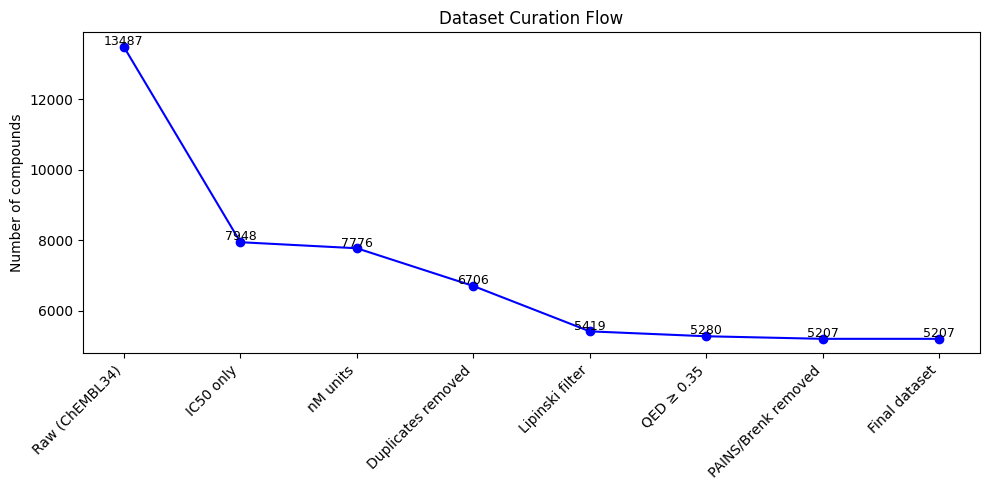

In [ ]:
import matplotlib.pyplot as plt

# Example counts from your preprocessing (replace with exact values)
steps = [
    "Raw (ChEMBL34)",
    "IC50 only",
    "nM units",
    "Duplicates removed",
    "Lipinski filter",
    "QED ≥ 0.35",
    "PAINS/Brenk removed",
    "Final dataset"
]
counts = [13487, 7948, 7776, 6706, 5419, 5280, 5207, 5207]

plt.figure(figsize=(10,5))
plt.plot(steps, counts, marker='o', color='b')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of compounds")
plt.title("Dataset Curation Flow")
for i, c in enumerate(counts):
    plt.text(i, c+50, str(c), ha='center', fontsize=9)
plt.tight_layout()
plt.show()


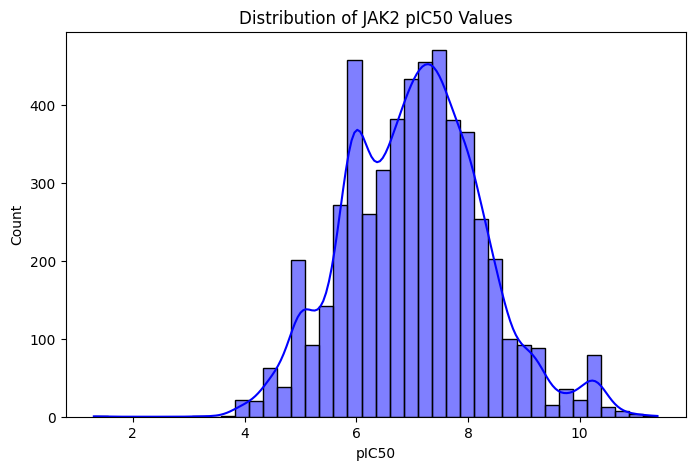

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.histplot(y, bins=40, kde=True, color="blue")
plt.xlabel("pIC50")
plt.ylabel("Count")
plt.title("Distribution of JAK2 pIC50 Values")
plt.show()


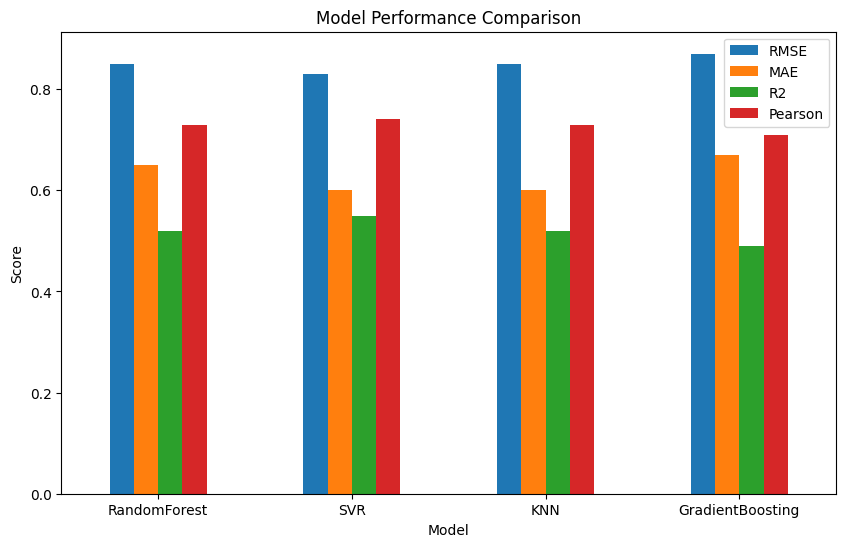

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example metrics from your results
data = {
    "Model": ["RandomForest", "SVR", "KNN", "GradientBoosting"],
    "RMSE": [0.85, 0.83, 0.85, 0.87],
    "MAE": [0.65, 0.60, 0.60, 0.67],
    "R2": [0.52, 0.55, 0.52, 0.49],
    "Pearson": [0.73, 0.74, 0.73, 0.71]
}
df = pd.DataFrame(data)

df.plot(x="Model", y=["RMSE","MAE","R2","Pearson"], kind="bar", figsize=(10,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()


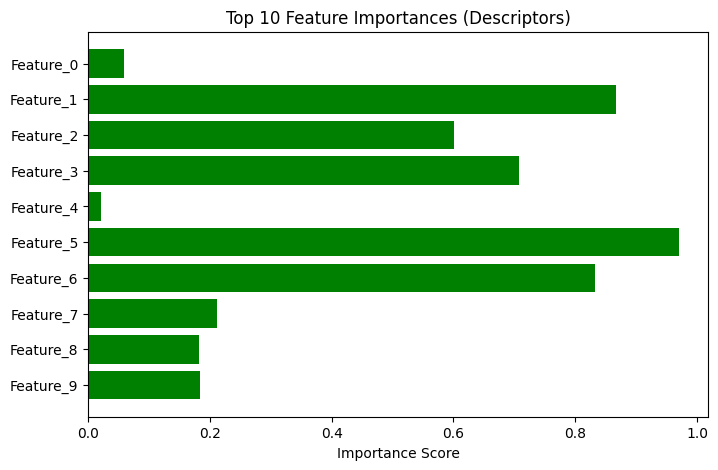

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example importances (replace with actual from permutation importance)
features = [f"Feature_{i}" for i in range(10)]
importances = np.random.rand(10)

plt.figure(figsize=(8,5))
plt.barh(features, importances, color="green")
plt.xlabel("Importance Score")
plt.title("Top 10 Feature Importances (Descriptors)")
plt.gca().invert_yaxis()
plt.show()


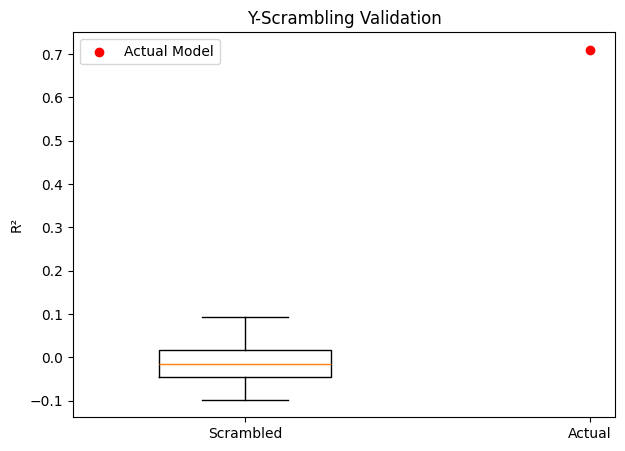

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

real_r2 = 0.71
scrambled_r2 = np.random.normal(0, 0.05, 50)  # Example distribution

plt.figure(figsize=(7,5))
plt.boxplot(scrambled_r2, positions=[1], widths=0.5)
plt.scatter(2, real_r2, color="red", label="Actual Model")
plt.xticks([1,2], ["Scrambled", "Actual"])
plt.ylabel("R²")
plt.title("Y-Scrambling Validation")
plt.legend()
plt.show()


Descriptors shape: (5280, 50)
Target shape: (5280,)


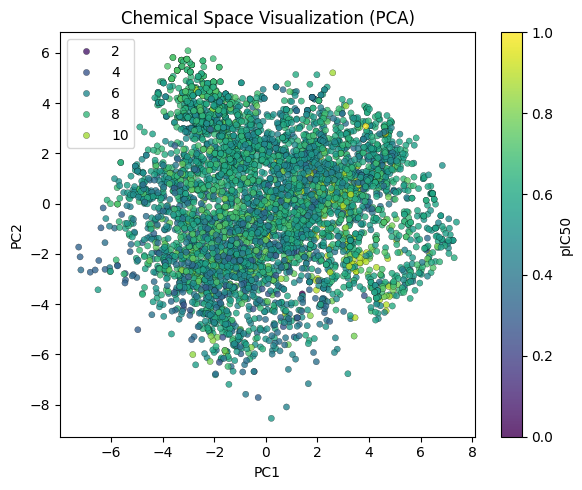

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


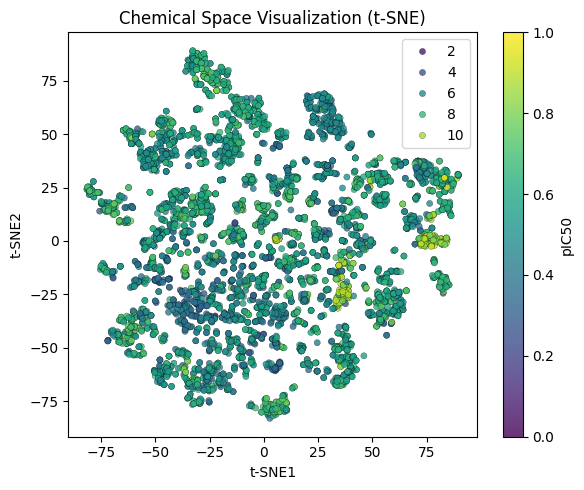

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# ✅ Use the final descriptors from Phase 4 (after selection)
X_desc = np.load("/content/drive/MyDrive/JAK2_Project/data/processed/X_desc_selected.npy")
y = np.load("/content/drive/MyDrive/JAK2_Project/data/processed/y.npy")

print("Descriptors shape:", X_desc.shape)
print("Target shape:", y.shape)

# Scale descriptors for PCA/t-SNE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_desc)

# --- PCA ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
scatter = sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=y, palette="viridis",
    s=20, alpha=0.8, edgecolor="k", linewidth=0.2
)
plt.colorbar(scatter.collections[0], label="pIC50")
plt.title("Chemical Space Visualization (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/JAK2_Project/results/chemical_space_pca.png", dpi=300)
plt.show()

# --- t-SNE ---
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
scatter = sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=y, palette="viridis",
    s=20, alpha=0.8, edgecolor="k", linewidth=0.2
)
plt.colorbar(scatter.collections[0], label="pIC50")
plt.title("Chemical Space Visualization (t-SNE)")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/JAK2_Project/results/chemical_space_tsne.png", dpi=300)
plt.show()


Short listed Drug

In [ ]:
# =========================
# Top 50 Most Relevant Drugs Extraction
# =========================

import os
import numpy as np
import pandas as pd
import joblib

# --------------------------
# 0. Paths
# --------------------------
project_path = "/content/drive/MyDrive/JAK2_Project"
processed_path = os.path.join(project_path, "data", "processed")
models_path = os.path.join(project_path, "models")
results_path = os.path.join(project_path, "results")
os.makedirs(results_path, exist_ok=True)

# --------------------------
# 1. Load cleaned & filtered compound info
# --------------------------
compound_file = os.path.join(processed_path, "jak2_filtered.csv")
df_compounds = pd.read_csv(compound_file)
print("✅ Loaded filtered compounds:", df_compounds.shape)

# --------------------------
# 2. Load RFE descriptor matrix
# --------------------------
X_desc_file = os.path.join(processed_path, "X_desc_selected.npy")
X_desc_rfe = np.load(X_desc_file)
print("✅ Loaded RFE descriptor matrix:", X_desc_rfe.shape)

# --------------------------
# 3. Load trained SVR model
# --------------------------
svr_model_file = os.path.join(models_path, "best_model_SVR.pkl")
svr_model = joblib.load(svr_model_file)
print("✅ Loaded trained SVR model")

# --------------------------
# 4. Predict pIC50
# --------------------------
predicted_pIC50 = svr_model.predict(X_desc_rfe)
print("✅ Prediction completed. Sample predictions:", predicted_pIC50[:5])

# --------------------------
# 5. Add predictions to dataframe
# Make sure row alignment is correct
# --------------------------
if len(df_compounds) != len(predicted_pIC50):
    raise ValueError("Row mismatch! Compounds and descriptors must align.")
df_compounds["predicted_pIC50"] = predicted_pIC50

# --------------------------
# 6. Sort by predicted pIC50 and get top 50
# --------------------------
top50_compounds = df_compounds.sort_values(
    by="predicted_pIC50", ascending=False
).head(50)

# --------------------------
# 7. Save results
# --------------------------
top50_file = os.path.join(results_path, "top50_most_relevant_compounds.csv")
top50_compounds.to_csv(top50_file, index=False)

print(f"✅ Top 50 most relevant compounds saved to:\n{top50_file}")
print("\nTop 5 compounds preview:")
print(top50_compounds.head())


✅ Loaded filtered compounds: (5280, 9)
✅ Loaded RFE descriptor matrix: (5280, 50)
✅ Loaded trained SVR model
✅ Prediction completed. Sample predictions: [7.35320208 8.42283475 7.52329595 7.64745552 8.05426106]
✅ Top 50 most relevant compounds saved to:
/content/drive/MyDrive/JAK2_Project/results/top50_most_relevant_compounds.csv

Top 5 compounds preview:
                                                Smiles  pIC50_calc  \
1306   CN(c1ccc(C#N)cn1)[C@@H]1CCN(c2ncnc3[nH]ccc23)C1   10.259637   
1307    CN(c1ccc(C#N)cn1)[C@H]1CCN(c2ncnc3[nH]ccc23)C1   10.259637   
890   CCN(c1ccc(C#N)cn1)[C@@H]1CCN(c2ncnc3[nH]ccc23)C1   10.259637   
1372     CN(c1ncccc1C#N)[C@@H]1CCN(c2ncnc3[nH]ccc23)C1   10.259637   
1355   CN(c1cnc(C#N)cn1)[C@@H]1CCN(c2ncnc3[nH]ccc23)C1   10.259637   

     Molecule ChEMBL ID Molecule Name       MW     LogP  HBD  HBA       QED  \
1306      CHEMBL3896481           NaN  319.372  1.93968  1.0  6.0  0.793942   
1307      CHEMBL3977509           NaN  319.372  1.93968  1.0  6.

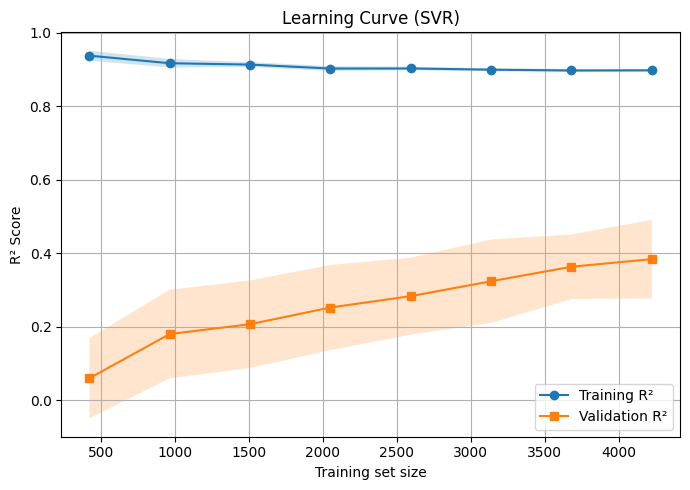

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.svm import SVR

# ✅ Load features & target
X = np.load("/content/drive/MyDrive/JAK2_Project/data/processed/X_desc_selected.npy")
y = np.load("/content/drive/MyDrive/JAK2_Project/data/processed/y.npy")

# Use best model (SVR from Phase 5)
estimator = SVR(kernel="rbf", C=10, gamma="scale")

train_sizes, train_scores, test_scores = learning_curve(
    estimator, X, y, cv=5, scoring="r2", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 8), random_state=42
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, label="Training R²", marker="o")
plt.plot(train_sizes, test_mean, label="Validation R²", marker="s")
plt.fill_between(train_sizes, train_mean - train_scores.std(axis=1),
                 train_mean + train_scores.std(axis=1), alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_scores.std(axis=1),
                 test_mean + test_scores.std(axis=1), alpha=0.2)
plt.xlabel("Training set size")
plt.ylabel("R² Score")
plt.title("Learning Curve (SVR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/JAK2_Project/results/learning_curve.png", dpi=300)
plt.show()
